# Creating Bayesian Model

Using the data from following table create a model predicting number of passenger deaths. Use poisson distribution in two variants

1. The rate is constant for all years and not depending on anything.
2. The intensity is constant, but rate is a product of intensity and miles flown.

Select appropriate priors, perform prior predictive checks, fit the model and using posterior predictive distribution predict the death rates from the model.

In [2]:
import os
from google.colab import drive
drive.mount('/content/gdrive')
working_directory = 'My Drive/DataAnalytics/'
wd="/content/gdrive/" + working_directory
os.chdir(wd)
import stan_utility

dirpath = os.getcwd()
print("current directory is : " + dirpath)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
current directory is : /content/gdrive/My Drive/DataAnalytics


In [0]:
!pip install arviz

In [0]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import arviz as az

In [0]:
import matplotlib.pyplot as plt
import matplotlib as mpl

light="#FFFCDC"
light_highlight="#FEF590"
mid="#FDED2A"
mid_highlight="#f0dc05"
dark="#EECA02"
dark_highlight="#BB9700"
green="#00FF00"
light_grey="#DDDDDD"

plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 200

In [0]:
# intialise data of lists. 
datadict = {'Year':[1976,1977,1978,1979,1980,1981,1982,1983,1984,1985],
        'FatalAcc':[24, 25, 31, 31, 22, 21, 26, 20, 16, 22], 
        'PassDeath':[734, 516, 754, 877, 814, 362, 764, 809, 223, 1066],
        'DeathRate':[0.19, 0.12, 0.15, 0.16, 0.14, 0.06, 0.13, 0.13, 0.03, 0.15],
        'MilesFlown':[3863.0, 4300.0, 5027.0, 5481.0, 5814.0, 6033.0, 5877.0, 6223.0, 7433.0, 7107.0]} 

# Create DataFrame 
datadf = pd.DataFrame(datadict).set_index('Year')
datadf
datadf['Miles flown [100 mln miles]']=np.round(datadf['PassDeath']/datadf['DeathRate'])

Model for predicting of passenger death

In [11]:
datadf['PassDeath']

0     734
1     516
2     754
3     877
4     814
5     362
6     764
7     809
8     223
9    1066
Name: PassDeath, dtype: int64

(array([1., 1., 0., 1., 0., 0., 4., 2., 0., 1.]),
 array([ 223. ,  307.3,  391.6,  475.9,  560.2,  644.5,  728.8,  813.1,
         897.4,  981.7, 1066. ]),
 <a list of 10 Patch objects>)

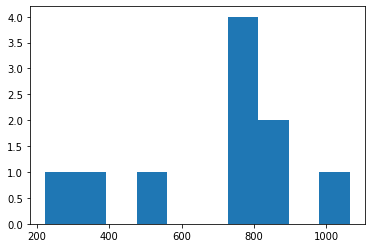

In [14]:
plt.hist(datadf['PassDeath'])

1. The rate is constant for all years and not depending on anything.

For constant rate and not depend on anything, so we will set lamda from the mean number of passenger death over period of time.

In [20]:
#setting lamda
lamda = datadf['PassDeath'].mean()

#setting sigma or standard deviation
sigma = np.std(datadf['PassDeath'])
print (lamda)
print (sigma)

691.9
239.43744485773314


Prior Predictive Checks

In [50]:
with open('passdeath_ppc.stan', 'r') as file:
    print(file.read())

generated quantities {
    // lamda is as a mean of passenger death : 619.9
    // sigma is set to : 239.43
    // since normal_rng(mu, sigma), then :
    real lamda = normal_rng(692,239);
    int deaths = poisson_rng(lamda);
}


In [51]:
model_ppc=stan_utility.compile_model('passdeath_ppc.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fa58b88e55da20d0daa788a1bc972ca8 NOW.


In [0]:
R = 1000
sim = model_ppc.sampling(data=dict(),
                         iter=R,
                         warmup=0,
                         refresh=R,
                         algorithm='Fixed_param',
                         seed=43541)

In [0]:
params_sim=sim.extract()
lambda_sim=params_sim['lamda']
deaths_sim=params_sim['deaths']

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


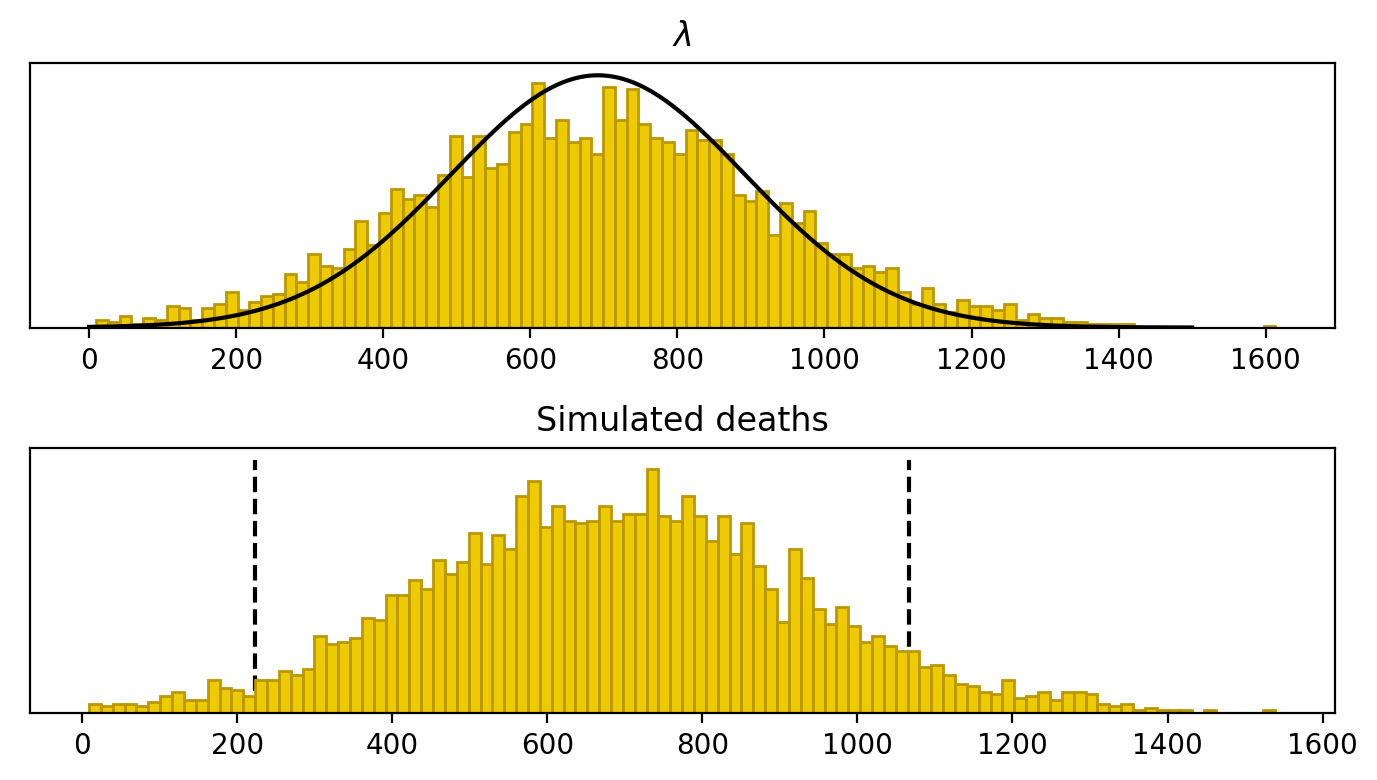

In [54]:
fig = plt.figure(figsize=(7, 4))

gs = fig.add_gridspec(2,1)
ax1 = fig.add_subplot(gs[1])
ax1.hist(deaths_sim,bins=100,color=dark,edgecolor=dark_highlight,density=True)
ax1.vlines([datadf['PassDeath'].min(),datadf['PassDeath'].max()],
           ymin=0,ymax=2e-3,linestyle='--',color='black',zorder=1)
# ax1.set_yticks([])
ax1.set_title('Simulated deaths')

ax2 = fig.add_subplot(gs[0])
ax2.hist(lambda_sim,bins=100,color=dark,edgecolor=dark_highlight,density=True)
x=np.linspace(0,1500,500)
y=stats.norm.pdf(x,loc=692,scale=200)
ax2.plot(x,y,'black')
ax2.set_title('$\lambda$')
ax1.set_yticks([])
ax2.set_yticks([])

fig.tight_layout()
plt.show()

Graphs above show ...

Posterior Predictive Checks

In [34]:
with open('passdeath_fit.stan', 'r') as file:
    print(file.read())

data {
    int N; //Number of our samples from data
    int deaths[N]; //Our deaths per year from data
}

parameters{
    real<lower=0> lambda;
}

model {
    lambda ~ normal(692,239);
    deaths ~ poisson(lambda);
}

generated quantities {
    int death = poisson_rng(lambda);
}


In [35]:
model_fit=stan_utility.compile_model('passdeath_fit.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_53795bdd4caea14a39bf383edb4fa402 NOW.


In [0]:
fit=model_fit.sampling(data=dict(N=len(datadf['PassDeath']),
                                 deaths=datadf['PassDeath']),
                       seed=43541)

In [42]:
az.summary(fit,var_names=['lambda'], round_to=2, kind='stats')

,mean,sd,hdi_3%,hdi_97%
lambda,691.83,8.33,676.32,707.42


In [0]:
params_fit=fit.extract()
lambda_fit=params_fit['lambda']
deaths_pred=params_fit['death']

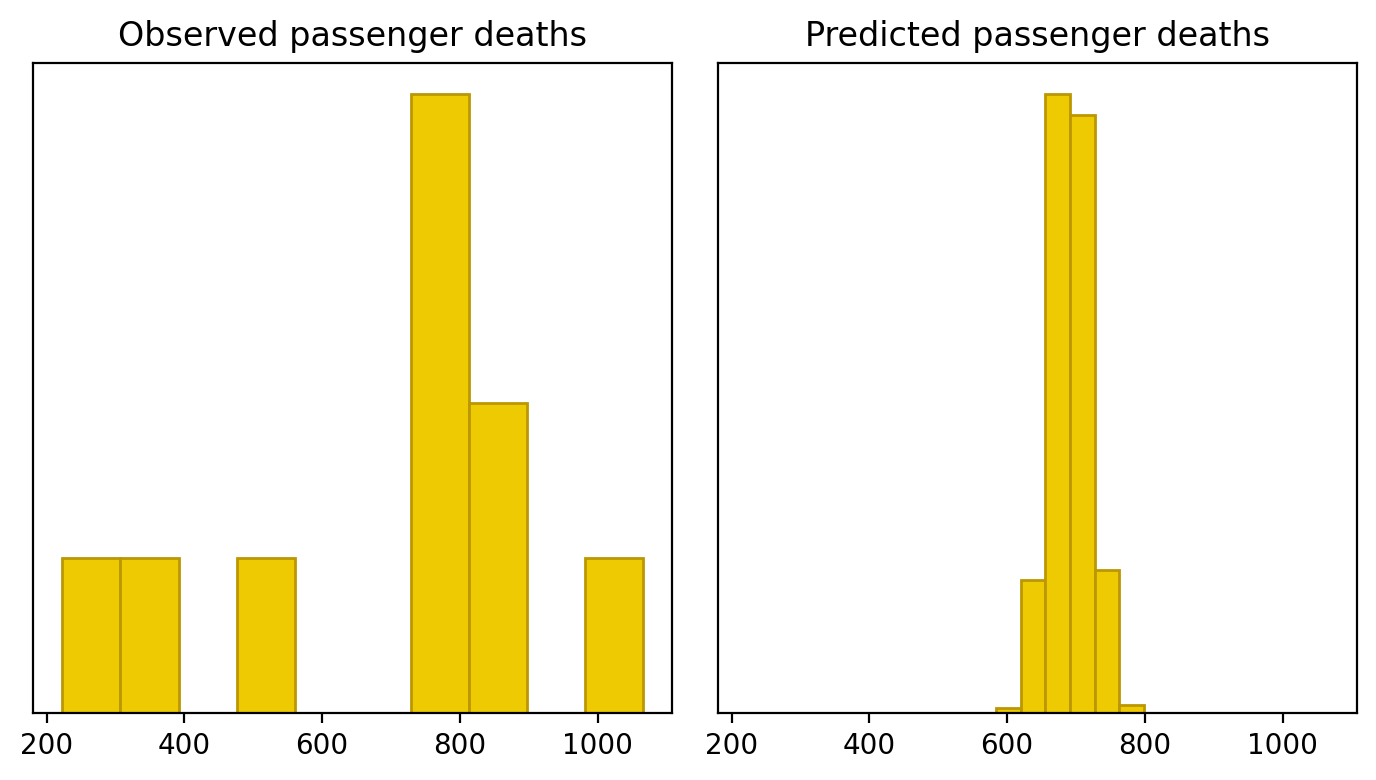

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(7, 4),sharex=True)
ax=axes[0]
ax.hist(datadf['PassDeath'],color=dark,edgecolor=dark_highlight,density=True)
ax.set_title('Observed passenger deaths')
ax.set_yticks(());
ax2=axes[1]
ax2.hist(deaths_pred,bins=6,color=dark,edgecolor=dark_highlight,density=True)
ax2.set_title('Predicted passenger deaths')
ax2.set_yticks(());
fig.tight_layout()

plt.show()

In [0]:
#using model for prediction

median_y_sim = np.median(y_sim.flatten())
cinf_y_sim = az.hpd(y_sim.flatten(),0.89)

print('Median of predicted accidents =',median_y_sim)
print('Confidence interval = [',*cinf_y_sim,']')

2. The intensity is constant, but rate is a product of intensity and miles flown.

In [8]:
#using death rate mean as an intensity
intensity = datadf['DeathRate'].mean()
print(intensity)

0.126


prior predictive

(array([1., 1., 0., 0., 0., 1., 3., 2., 1., 1.]),
 array([0.03 , 0.046, 0.062, 0.078, 0.094, 0.11 , 0.126, 0.142, 0.158,
        0.174, 0.19 ]),
 <a list of 10 Patch objects>)

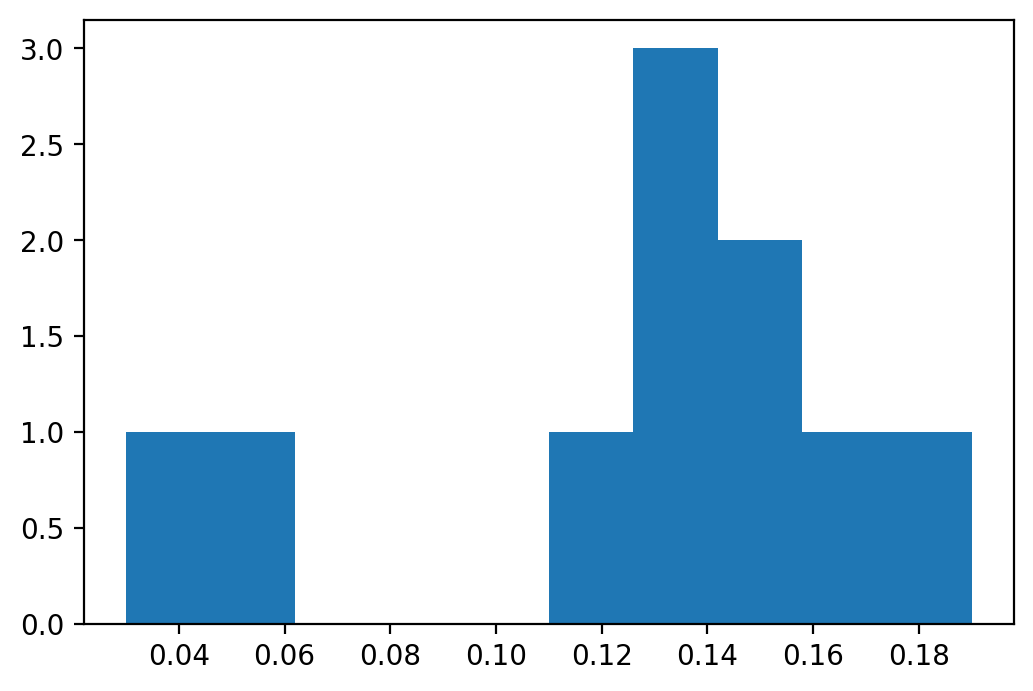

In [23]:
plt.hist(datadf['DeathRate'])

In [43]:
with open('intensity_ppc.stan', 'r') as file:
    print(file.read())

//sigma : 239.43
//beta=mu=intensity : 0.126
//alpha : 
//Generate a beta variate with positive prior successes (plus one) alpha and prior failures (plus one) beta;
//alpha = 0.02, beta = 0.19
data {
  int M;//number of years analyzed
  vector[M] miles; //number of miles flown each year
}

generated quantities {
  real beta=fabs(beta_rng(0.02,0.19));
  int deaths[M];
  for (k in 1:M) {
    deaths[k] = poisson_rng(beta*miles[k]);
  }
}



In [44]:
model_prior=stan_utility.compile_model('intensity_ppc.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_74eac774ee9d15a3888e7e16d4ab0236 NOW.


In [0]:
R=1000
data_prior=dict(M=len(datadf),miles=datadf['Miles flown [100 mln miles]'].to_numpy())
intensity_sim=model_prior.sampling(data=data_prior,algorithm="Fixed_param", iter=R, warmup=0, chains=1, refresh=R,
                     seed=43541)

Text(0.5, 1.0, 'beta')

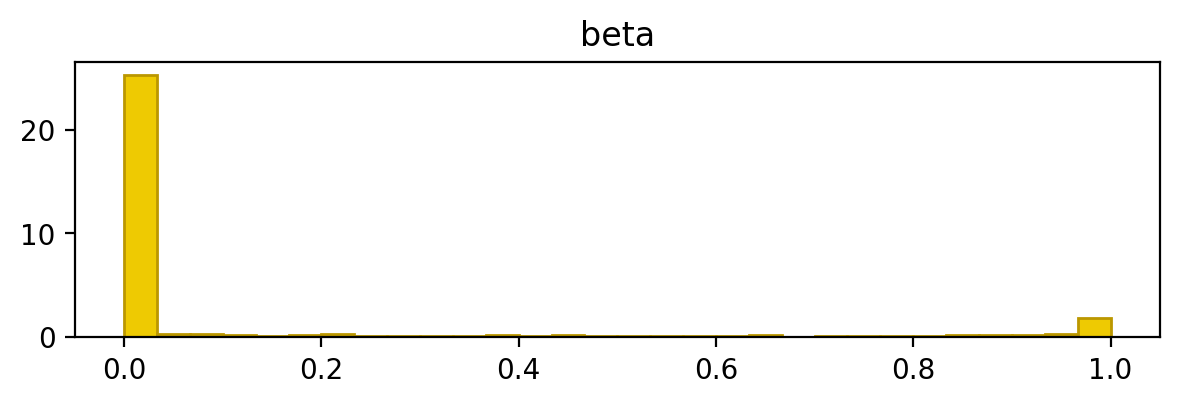

In [58]:
params=intensity_sim.extract()
beta=params['beta']

fig = plt.figure(figsize=(7, 4))

gs = fig.add_gridspec(2,1)
ax1 = fig.add_subplot(gs[1])
ax1.hist(beta,bins=30,color=dark,edgecolor=dark_highlight,density=True)
ax1.vlines([datadf['DeathRate'].min(),datadf['DeathRate'].max()],
           ymin=0,ymax=2e-3,linestyle='--',color='black',zorder=1)
# ax1.set_yticks([])
ax1.set_title('beta')

In [0]:
R=1000
data_sim=dict(M=50,
              miles=np.linspace(datadf['Miles flown [100 mln miles]'].min(),
                                datadf['Miles flown [100 mln miles]'].max()))
                                   
rate_sim = model_prior.sampling(data=data_sim,
                                   iter=R,
                                   warmup=0,
                                   chains=1,
                                   refresh=R,
                                   algorithm='Fixed_param',
                                   seed=43541)

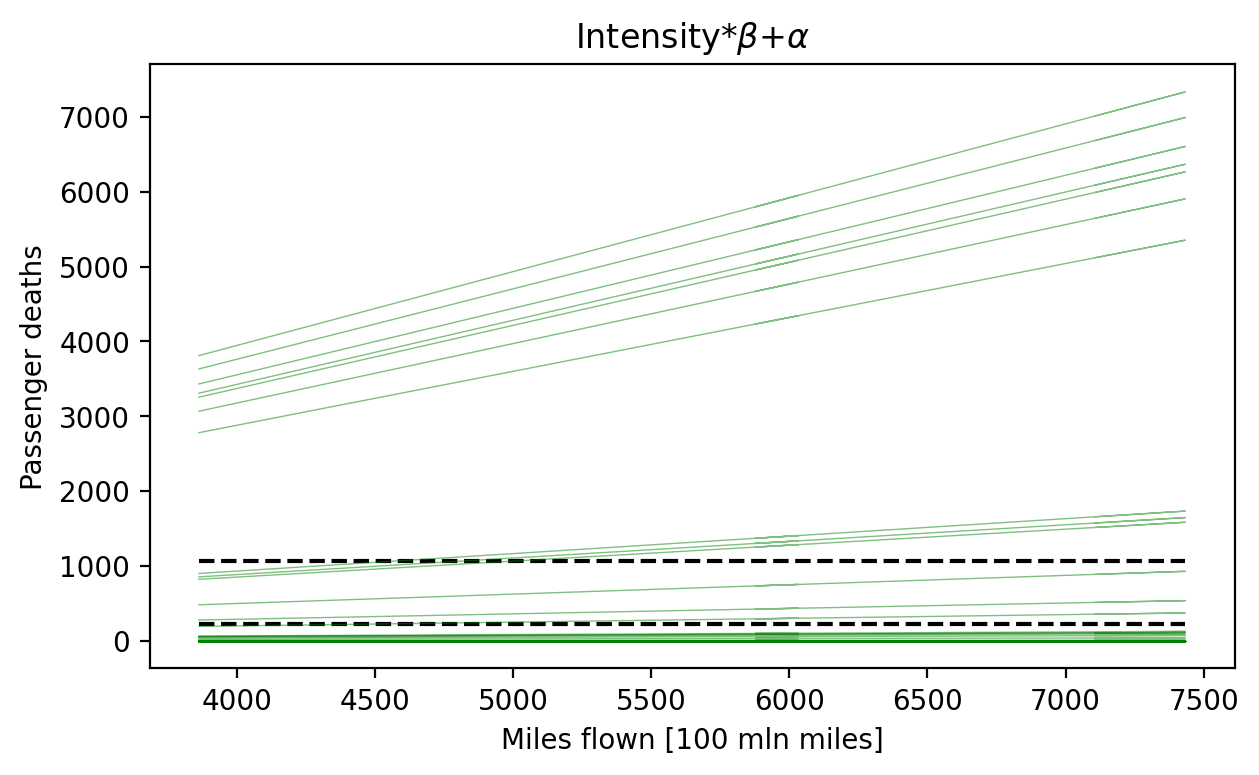

In [64]:
params_sim=rate_sim.extract()
beta_sim=params['beta']

fig, axes = plt.subplots(1, 1, figsize=(7, 4))
axes.hlines([datadf['PassDeath'].min(),
             datadf['PassDeath'].max()],
            xmin=datadf['Miles flown [100 mln miles]'].min(),
            xmax=datadf['Miles flown [100 mln miles]'].max(),
            linestyles='--',
            colors='black')
for i in range(100):
    axes.plot(datadf['Miles flown [100 mln miles]'],
              beta_sim[i]*datadf['Miles flown [100 mln miles]'],
              color='green',
              alpha=0.5,
              linewidth=0.5)
axes.set_xlabel('Miles flown [100 mln miles]')
axes.set_ylabel('Passenger deaths')
axes.set_title(r'Intensity*$\beta$+$\alpha$')
plt.show()

In [0]:
deaths_rate_sim=params_sim['deaths']

In [0]:
fig, axes = plt.subplots(1, 1, figsize=(7,4))
axes = ribbon_plot(data_sim['Miles'],deaths_rate_sim,axes)
axes.scatter(Airline_data['Miles flown [100 mln miles]'],
             Airline_data['Passenger deaths'],
             color='black',
             alpha=0.2,
             s=10)
axes.set_xlabel('Miles flown [100 mln miles]')
axes.set_ylabel('Passenger deaths')
plt.show()